In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [78]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
local_dir = r"C:\Users\Utente\Downloads\data\\"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [79]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Organization', 'Receiving Organization', 'Participants', 'Field of Education']]
    return df

mobility_df = filter_data(mobility_df)

for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()
        
display(mobility_df)

,Sending Organization,Receiving Organization,Participants,Field of Education
1701,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,ABO AKADEMI,1,Education
1702,PRIVATE PÄDAGOGISCHE HOCHSCHULE - HOCHSCHULSTI...,MALMOE HOEGSKOLA (MALMOE UNIVERSITY),2,Education
1733,IMC FACHHOCHSCHULE KREMS GMBH,HASKOLINN A BIFROST,1,Business and administration
1734,IMC FACHHOCHSCHULE KREMS GMBH,LAUREA-AMMATTIKORKEAKOULU OY,1,"Travel, tourism and leisure"
1735,IMC FACHHOCHSCHULE KREMS GMBH,METROPOLIA AMMATTIKORKEAKOULU OY,1,"Business, administration and law"
...,...,...,...,...
716937,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Political sciences and civics
716938,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Pharmacy
716939,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,1,Pharmacy
716940,HEBRON UNIVERSITY,UNIVERSITY OF BRADFORD,3,Pharmacy


In [80]:
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not further defined','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', inter-disciplinary programmes','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classified','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(' not elsewhere classified','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classifed','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.lower()
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.strip()

In [7]:
print(mobility_df['Field of Education'].nunique())
for f in np.sort(mobility_df['Field of Education'].unique()):
    print(f)

106
accounting and taxation
agriculture
agriculture, forestry, fisheries and veterinary
architecture and construction
architecture and town planning
arts
arts and humanities
audio-visual techniques and media production
biochemistry
biological and related sciences
biology
building and civil engineering
business and administration
business, administration and law
care of the elderly and of disabled adults
chemical engineering and processes
chemistry
child care and youth services
community sanitation
computer use
crop and livestock production
database and network design and administration
dental studies
domestic services
earth sciences
economics
education
education science
electricity and energy
electronics and automation
engineering and engineering trades
engineering, manufacturing and construction
environment
environmental protection technology
environmental sciences
fashion, interior and industrial design
finance, banking and insurance
fine arts
fisheries
food processing
forestry
hair 

### Field standardisation

In [76]:
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and Humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences, J. and I.': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, Admin. and Law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Natural sciences, M. and S.': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'ICTs': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, M. and C.': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, F., F. and V.': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and Welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

In [81]:
mobility_df['Field of Education'] = mobility_df['Field of Education'].apply(standard_field)

In [10]:
print(mobility_df['Field of Education'].nunique())
for f in np.sort(mobility_df['Field of Education'].unique()):
    print(f)

10
Agriculture, forestry, fisheries and veterinary
Arts and humanities
Business, administration and law
Education
Engineering, manufacturing and construction
Health and welfare
Information and Communication Technologies (ICTs)
Natural sciences, mathematics and statistics
Services
Social sciences, journalism and information


### Students and universities in each field of education

In [21]:
def get_field_data(data):
    #students
    field_count = data.groupby('Field of Education')['Participants'].sum()
    field_count.sort_values(inplace=True, ascending=False)
    field_count.name = 'Students'
    #universities
    field_uni_s = data.groupby('Field of Education')['Sending Organization'].unique()
    field_uni_r = data.groupby('Field of Education')['Receiving Organization'].unique()
    for i in range(len(field_uni_s)):
        field_uni_s[i] = len(set(field_uni_s[i]) | set(field_uni_r[i]))
    field_uni = field_uni_s.sort_values(ascending=False)
    field_uni.name = 'Universities'
    #merging
    fields_data = pd.concat([field_count, field_uni], axis=1)
    fields_data['% of students'] = 100 * fields_data['Students'] / data['Participants'].sum()
    fields_data['% of students'] = fields_data['% of students'].apply(lambda x: '{:.2f}%'.format(x))
    tot_uni = len(set(data['Sending Organization'].unique()) | set(data['Receiving Organization'].unique()))
    fields_data['% of universities'] = 100 * fields_data['Universities'] / tot_uni
    fields_data['% of universities'] = fields_data['% of universities'].apply(lambda x: '{:.2f}%'.format(x))
    fields_data.index=['Business, Admin. and Law','Arts and Humanities', 'Engineering, M. and C.','Social sciences, J. and I.','Health and welfare','Natural sciences, M. and S.','Education','Services','ICTs','Agriculture, F., F. and V.']
    
    return fields_data

In [32]:
fields14to19 = get_field_data(mobility_df)
fields14to19

,Students,Universities,% of students,% of universities
"Business, Admin. and Law",351816,3813,26.55%,53.40%
Arts and Humanities,278919,3890,21.05%,54.48%
"Engineering, M. and C.",200065,3317,15.10%,46.46%
"Social sciences, J. and I.",195460,3383,14.75%,47.38%
Health and welfare,72680,1903,5.48%,26.65%
"Natural sciences, M. and S.",72202,2459,5.45%,34.44%
Education,48950,2196,3.69%,30.76%
Services,46997,2381,3.55%,33.35%
ICTs,38182,2433,2.88%,34.08%
"Agriculture, F., F. and V.",19873,1036,1.50%,14.51%


### Over the years

In [22]:
mobility14 = pd.read_csv(local_dir+'data_clean14.csv', index_col=0)
mobility15 = pd.read_csv(local_dir+'data_clean15.csv', index_col=0)
mobility16 = pd.read_csv(local_dir+'data_clean16.csv', index_col=0)
mobility17 = pd.read_csv(local_dir+'data_clean17.csv', index_col=0)
mobility18 = pd.read_csv(local_dir+'data_clean18.csv', index_col=0)
mobility19 = pd.read_csv(local_dir+'data_clean19.csv', index_col=0)

In [23]:
fields14 = get_field_data(mobility14)
fields15 = get_field_data(mobility15)
fields16 = get_field_data(mobility16)
fields17 = get_field_data(mobility17)
fields18 = get_field_data(mobility18)
fields19 = get_field_data(mobility19)

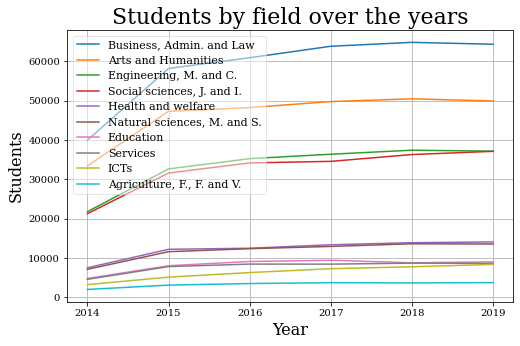

In [61]:
students_df = pd.concat([fields14['Students'],fields15['Students'],fields16['Students'],fields17['Students'],fields18['Students'],fields19['Students']], axis=1)
years = [2014,2015,2016,2017,2018,2019]
students_df.columns = years
students_df = students_df.transpose()

plt.rc('font', family='serif')
fig = plt.figure(figsize=(8,5))
for field in students_df.columns:
    plt.plot(years, students_df[field], label = field)
plt.legend(loc='upper left', framealpha=0.5, fontsize=11)
plt.xlabel('Year', size=16)
plt.ylabel('Students', size=16)
plt.title('Students by field over the years', size=22)
plt.grid(which='major')
plt.show()

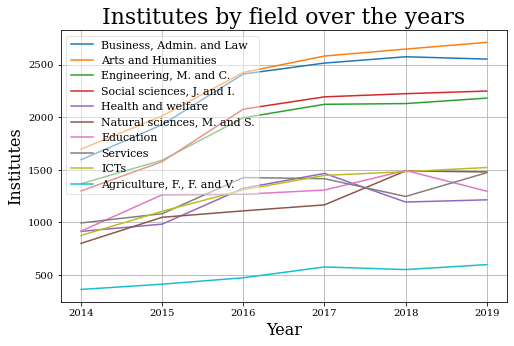

In [72]:
unis_df = pd.concat([fields14['Universities'],fields15['Universities'],fields16['Universities'],fields17['Universities'],fields18['Universities'],fields19['Universities']], axis=1)
years = [2014,2015,2016,2017,2018,2019]
unis_df.columns = years
unis_df = unis_df.transpose()

plt.rc('font', family='serif')
fig = plt.figure(figsize=(8,5))
for field in unis_df.columns:
    plt.plot(years, unis_df[field], label = field)
plt.legend(loc='upper left', framealpha=0.5, fontsize=11)
plt.xlabel('Year', size=16)
plt.ylabel('Institutes', size=16)
plt.title('Institutes by field over the years', size=22)
plt.grid(which='major')
plt.show()

### Universities in the giant component by field of education

In [83]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
print(ns.fraction_in_giant(adj_matrix_crs))

0.996218487394958


In [84]:
dd = {}
for field in mobility_df['Field of Education'].unique():
    temp_df = mobility_df.loc[mobility_df['Field of Education'] == field]
    temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    dd[field] = ns.fraction_in_giant(temp_adj)
field_df = pd.DataFrame.from_dict(dd, orient='index', columns=['Percentage'])
pd.set_option('display.max_rows', 10)
field_df = field_df.sort_values('Percentage', ascending=False)
field_df['Percentage'] = (100*field_df['Percentage']).apply(lambda x: '{:.2f}%'.format(x))
field_df

,Percentage
Arts and Humanities,54.10%
"Business, Admin. and Law",53.10%
"Social sciences, J. and I.",47.09%
"Engineering, M. and C.",46.11%
"Natural sciences, M. and S.",34.15%
ICTs,33.68%
Services,33.03%
Education,30.48%
Health and Welfare,26.41%
"Agriculture, F., F. and V.",14.20%


Universities in the giant component when removing fields.

In [86]:
fields = mobility_df['Field of Education'].unique()
dd = {}
for field in fields:
    temp_df = mobility_df.loc[mobility_df['Field of Education'] != field]
    temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    dd[field] = ns.fraction_in_giant(temp_adj)
field_df = pd.DataFrame.from_dict(dd, orient='index', columns=['Percentage'])
field_df = field_df.sort_values('Percentage')
field_df['Percentage'] = (100*field_df['Percentage']).apply(lambda x: '{:.2f}%'.format(x))
print('Percentages removing 1 field of education:')
display(field_df.head(10))

Percentages removing 1 field of education:


,Percentage
Arts and Humanities,88.64%
"Business, Admin. and Law",94.62%
"Engineering, M. and C.",95.07%
Health and Welfare,96.88%
"Social sciences, J. and I.",97.14%
Services,97.70%
"Natural sciences, M. and S.",97.75%
ICTs,98.25%
Education,98.38%
"Agriculture, F., F. and V.",98.70%


### Greedy approach
We add one field at a time, maximising the percentage of nodes in the giant component.
We want to see how many are necessary to connect almost all universities.

In [88]:
added_fields = []
remaining_fields = list(mobility_df['Field of Education'].unique())
giant_perc_add =[]
while len(remaining_fields):
    d = {}
    for field in remaining_fields:
        temp_df = mobility_df.loc[mobility_df['Field of Education'].isin(added_fields+[field])]
        temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        d[field] = ns.fraction_in_giant(temp_adj)
    new_field = max(d, key=d.get)
    added_fields.append(new_field)
    remaining_fields.remove(new_field)
    giant_perc_add.append(d[new_field])

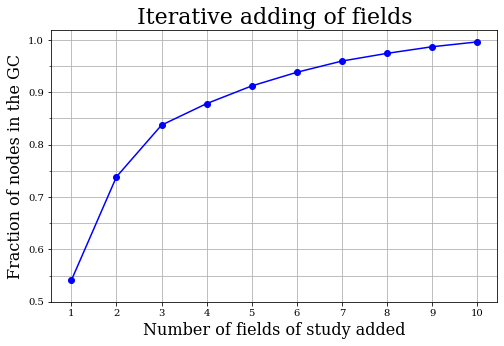

In [106]:
from matplotlib.ticker import (AutoMinorLocator)

fig, ax = plt.subplots(figsize=(8,5))
ax.grid(which='major')
ax.plot([i+1 for i in range(len(giant_perc_add))], giant_perc_add, 'bo-')
ax.set_xlabel('Number of fields of study added', size=16)
ax.set_ylabel('Fraction of nodes in the GC', size=16)
ax.set_xticks(np.arange(1,11))
ax.set_yticks(np.arange(0.5,1.01,0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='minor', axis='y')
ax.set_title('Iterative adding of fields', size=22)
plt.show()


In [108]:
adding_fields_df = pd.DataFrame({'Percentage' : giant_perc_add}, index=added_fields).sort_values('Percentage')
print('Adding the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:')
adding_fields_df['Percentage'] = (100*adding_fields_df['Percentage']).apply(lambda x: '{:.2f}%'.format(x))
display(adding_fields_df)

Adding the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:


,Percentage
Arts and Humanities,54.10%
"Business, Admin. and Law",73.87%
"Engineering, M. and C.",83.74%
Health and Welfare,87.84%
"Social sciences, J. and I.",91.22%
"Natural sciences, M. and S.",93.82%
Services,95.97%
ICTs,97.44%
Education,98.70%
"Agriculture, F., F. and V.",99.62%


We do the same, but removing fields iteratively, minimising the percentage of nodes in the giant component

In [110]:
removed_fields = []
remaining_fields = list(mobility_df['Field of Education'].unique())
giant_perc_rem =[]
while len(remaining_fields):
    d = {}
    for field in remaining_fields:
        temp_df = mobility_df.loc[~mobility_df['Field of Education'].isin(removed_fields+[field])]
        temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        d[field] = ns.fraction_in_giant(temp_adj)
    new_field = min(d, key=d.get)
    removed_fields.append(new_field)
    remaining_fields.remove(new_field)
    giant_perc_rem.append(d[new_field])

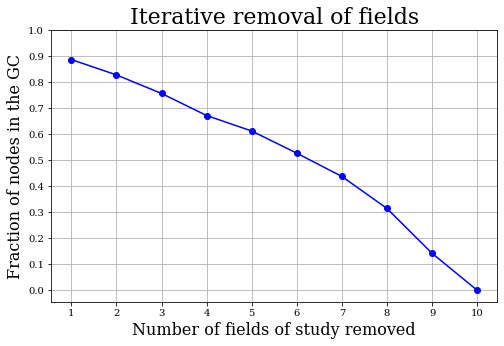

In [115]:
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(which='major')
ax.plot([i+1 for i in range(len(giant_perc_rem))], giant_perc_rem, 'bo-')
ax.set_xlabel('Number of fields of study removed', size=16)
ax.set_ylabel('Fraction of nodes in the GC', size=16)
ax.set_xticks(np.arange(1,11))
ax.set_yticks(np.arange(0,1.01,0.1))
#ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#ax.grid(which='minor', axis='y')
ax.set_title('Iterative removal of fields', size=22)
plt.show()

In [116]:
removing_fields_df = pd.DataFrame({'Percentage' : giant_perc_rem}, index=removed_fields).sort_values('Percentage', ascending=False)
print('Removing the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:')
removing_fields_df['Percentage'] = (100*removing_fields_df['Percentage']).apply(lambda x: '{:.2f}%'.format(x))
display(removing_fields_df)

Removing the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:


,Percentage
Arts and Humanities,88.64%
"Business, Admin. and Law",82.75%
"Social sciences, J. and I.",75.62%
"Engineering, M. and C.",67.14%
ICTs,61.19%
"Natural sciences, M. and S.",52.68%
Services,43.73%
Education,31.43%
Health and Welfare,14.20%
"Agriculture, F., F. and V.",0.01%
